In [1]:
import os
import sys
os.path.abspath(os.curdir)
os.chdir("..")
ML_FOLDER_PATH = os.path.abspath(os.curdir)
sys.path.append(ML_FOLDER_PATH)
import implementations as impl
import numpy as np
import matplotlib.pyplot as plt
import src.helpers as hlp
%matplotlib inline

## Import Data
We first imported the data separated in jets as explained in the data processing

In [2]:
jet_0, jet_1, jet_2_3 = hlp.load_split_data(ML_FOLDER_PATH + "/data/train.csv", one_hot=False)
jet_0, jet_1, jet_2_3 = hlp.process_data(jet_0, jet_1, jet_2_3)

The datasets have by default a polynomial expension of degree 2 and labels are {-1, 1}. They also have the nan replaced by the means of this feature and are standardized. If the feature is all nan, it is dropped.

### Prepare for training

We split the dataset into a training set and a validation set.

In [3]:
def split_train_val(data, seed, part = 0.8):
    """seperates the dataset into a training set and a validation set

    Args:
        data (Anx): dataset
        seed (Int): seed for the random shuffle
        part (float, optional): part of the dataset that forms the train set. Defaults to 0.8.

    Returns:
        Any: train set, validation set
    """
    data = np.array(data)
    np.random.seed(seed)
    split_idx = int(part * data.shape[0])
    np.random.shuffle(data)
    train_data = data[:split_idx, :]
    val_data = data[split_idx:, :]
    return train_data, val_data

We still need to separe into Id, labels and data

In [4]:
def split_data(data):
    """Given the dataset, splits it in Id, y, x

    Args:
        data (Any): jet datasets

    Returns:
        Any: Id, y, x
    """
    return data[:, 0], data[:, 1], data[:, 2:]

### Plot

We will need to plot the accuracy and loss of each parameter

In [5]:
def plot_acc_loss(values, acc, loss, plot=True):
    """plot the loss and accuracy of the given values

    Args:
        values ([]float): tested values
        acc ([]float): accuracy with the given values
        loss ([]float): loss with the given values

    Returns:
        float, float, float: best accuracy, loss and value
    """
    index_best_config = np.array(acc).argmax()
    print("Best accuracy : {} with loss : {} and value : {}"
    .format(acc[index_best_config], loss[index_best_config], values[index_best_config]))
    if plot :
        fig, (acc_plot, loss_plot) = plt.subplots(1, 2)
        plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
        acc_plot.set_title("accuracy")
        loss_plot.set_title("loss")
        acc_plot.plot(values, acc, linestyle="-", marker="o")
        loss_plot.plot(values, loss, linestyle="-", marker="o")   
        acc_plot.plot(values[index_best_config], acc[index_best_config] , marker="o", color='r')
        loss_plot.plot(values[index_best_config], loss[index_best_config] , marker="o", color='r')
        plt.show()
    return acc[index_best_config], loss[index_best_config], values[index_best_config]

### Accuracy

In [6]:
def compute_acc(w, x_val, y_val):
    """Computes the accuracy of the binary classifier using labels {-1, 1}

    Args:
        w ([] float): weights
        x_val ([] float): data from validation set
        y_val ([] float): labels from validation set

    Returns:
        float: accuracy
    """
    pred = np.dot(x_val, w)
    pred = np.where(pred > 0, 1, -1)
    return (pred == y_val).mean()

In [7]:
def compute_acc_log(w, x_val, y_val):
    """Computes the accuracy of the binary classifier using labels {0, 1}

    Args:
        w ([] float): weights
        x_val ([] float): data from validation set
        y_val ([] float): labels from validation set

    Returns:
        float: accuracy
    """
    pred = np.dot(x_val, w)
    pred = np.where(pred > 0.5, 1, 0)
    return (pred == y_val).mean()

### Grid search

For each model we will do a grid search to find the best parameters

#### Least Squares

### Ridge Regression

In [8]:
ridge_values = [0.001, 0.01, 0.1, 0.2, 0.3]

In [9]:
def grid_search_ridge(ridge_values, x_train, y_train, x_val, y_val, plot=True):
    """Does the grid search for the ridge regression model. Outputs and plot the accuracy and loss of each model

    Args:
        ridge_values ([] float): ridge values for the grid search
        x_train ([] float]): data for training
        y_train ([] float): labels for training
        x_val ([] float): data for validation
        y_val ([] float): labels for validatio
        plot (bool, optional): decides if we want the function to plot or not. Defaults to True.

    Returns:
        float, float, float: return the model with the best accuracy and corresponding loss and value
    """
    acc = []
    loss = []
    for lambda_ in ridge_values:
        w, l = impl.ridge_regression(y_train, x_train, lambda_)
        a = compute_acc(w, x_val, y_val)
        loss.append(l)
        acc.append(a)
    best_acc, best_loss, value = plot_acc_loss(ridge_values, acc, loss, plot=plot)
    return best_acc, best_loss, value


### Gradient descent

In [10]:
gammas = [0.001, 0.01, 0.1, 0.2, 0.3]

In [11]:
def grid_search_gamma(gammas, x_train, y_train, x_val, y_val, plot=True):
    """Does the grid search for the mean squared error gradient descent model. Outputs and plot the accuracy and loss of each model

    Args:
        gammas ([] float): gamma values for the grid search
        x_train ([] float]): data for training
        y_train ([] float): labels for training
        x_val ([] float): data for validation
        y_val ([] float): labels for validatio
        plot (bool, optional): decides if we want the function to plot or not. Defaults to True.

    Returns:
        float, float, float: return the model with the best accuracy and corresponding loss and value
    """
    acc = []
    loss = []
    w0 = np.random.rand(x_train.shape[1])
    for gamma in gammas:
        w, l = impl.mean_squared_error_gd(y_train, x_train, w0, max_iters=100, gamma=gamma)
        a = compute_acc(w, x_val, y_val)
        loss.append(l)
        acc.append(a)
    best_acc, best_loss, value = plot_acc_loss(gammas, acc, loss, plot)
    return best_acc, best_loss, value


### Stochastich gradient

In [12]:
def grid_search_stoch_gamma(gammas, x_train, y_train, x_val, y_val, plot=True):
    """Does the grid search for the mean squared error stochastic gradient descent model. Outputs and plot the accuracy and loss of each model

    Args:
        gammas ([] float): gamma values for the grid search
        x_train ([] float]): data for training
        y_train ([] float): labels for training
        x_val ([] float): data for validation
        y_val ([] float): labels for validatio
        plot (bool, optional): decides if we want the function to plot or not. Defaults to True.

    Returns:
        float, float, float: return the model with the best accuracy and corresponding loss and value
    """
    acc = []
    loss = []
    w0 = np.random.rand(x_train.shape[1])
    for gamma in gammas:
        w, l = impl.mean_squared_error_sgd(y_train, x_train, w0, max_iters=100, gamma=gamma)
        a = compute_acc(w, x_val, y_val)
        loss.append(l)
        acc.append(a)
    best_acc, best_loss, value = plot_acc_loss(gammas, acc, loss, plot)
    return best_acc, best_loss, value



### Logistic regression

For the logistic regression be need the labels to be {0,1} to avoid logarithm explosion. For this reason we need to import again the data and changing "label" to false.

In [13]:
jet_0, jet_1, jet_2_3 = hlp.load_split_data(ML_FOLDER_PATH + "/data/train.csv", one_hot=True)
jet_0, jet_1, jet_2_3 = hlp.process_data(jet_0, jet_1, jet_2_3)

In [14]:
def grid_search_log_gamma(gammas, x_train, y_train, x_val, y_val, plot=True):
    """Does the grid search for the logistic regression gradient descent model. Outputs and plot the accuracy and loss of each model

    Args:
        gammas ([] float): gamma values for the grid search
        x_train ([] float]): data for training
        y_train ([] float): labels for training
        x_val ([] float): data for validation
        y_val ([] float): labels for validatio
        plot (bool, optional): decides if we want the function to plot or not. Defaults to True.

    Returns:
        float, float, float: return the model with the best accuracy and corresponding loss and value
    """
    acc = []
    loss = []
    w0 = np.random.rand(x_train.shape[1])
    for gamma in gammas:
        w, l = impl.logistic_regression(y_train, x_train, w0, max_iters=100, gamma=gamma)
        a = compute_acc_log(w, x_val, y_val)
        loss.append(l)
        acc.append(a)
    best_acc, best_loss, value = plot_acc_loss(gammas, acc, loss, plot)
    return best_acc, best_loss, value

### Regularized logistic regression

In [15]:
lambdas_ = [0.001, 0.1, 0.3]

In [16]:
def grid_search_reg_log_gamma(gammas, lambdas_, x_train, y_train, x_val, y_val,plot = True):
    """Does the grid search for the regularized logistic regression gradient descent model. Outputs and plot the accuracy and loss of each model

    Args:
        gammas ([] float): gamma values for the grid search
        x_train ([] float]): data for training
        y_train ([] float): labels for training
        x_val ([] float): data for validation
        y_val ([] float): labels for validatio
        plot (bool, optional): decides if we want the function to plot or not. Defaults to True.

    Returns:
        float, float, float: return the model with the best accuracy and corresponding loss and value
    """
    lambda_gamma = []
    w0 = np.random.rand(x_train.shape[1])
    for i,lambda_ in enumerate(lambdas_):
        acc = []
        loss = []
        g = []
        for gamma in gammas :
            g.append(gamma)
            w, l = impl.reg_logistic_regression(y_train, x_train,lambda_, w0, max_iters=100, gamma=gamma)
            a = compute_acc_log(w, x_val, y_val)
            loss.append(l)
            acc.append(a)
        lambda_gamma.append(g)
        print("Lambda value : {}".format(lambda_))
        best_acc, best_loss, value = plot_acc_loss(lambda_gamma[i], acc, loss, plot=plot)
    return best_acc, best_loss, value

### Polynomial expension degree

To complete our grid search, we will do the full search that we have prepared but we will increment our dataset with a polynomial extension. We used the even degrees in the range [2,12]

In [17]:
degrees = range(2, 13, 2)

#### Least Squares

In [18]:
a_0 = []
l_0 = []
a_1 = []
l_1 = []
a_2_3 = []
l_2_3 = []
for d in degrees:
        print("====== degree {} ======".format(d))
        deg = np.arange(2, d, 2)

        jet_0, jet_1, jet_2_3 = hlp.load_split_data(ML_FOLDER_PATH + "/data/train.csv", one_hot=False)
        jet_0, jet_1, jet_2_3 = hlp.process_data(jet_0, jet_1, jet_2_3, deg=deg)
        jet_0_train, jet_0_val = split_train_val(jet_0, 40)
        jet_1_train, jet_1_val = split_train_val(jet_1, 41)
        jet_2_3_train, jet_2_3_val = split_train_val(jet_2_3, 42)

        id_jet_0_train, y_jet_0_train, x_jet_0_train = split_data(jet_0_train)
        id_jet_0_val, y_jet_0_val, x_jet_0_val = split_data(jet_0_val) 
        id_jet_1_train, y_jet_1_train, x_jet_1_train = split_data(jet_1_train)
        id_jet_1_val, y_jet_1_val, x_jet_1_val = split_data(jet_1_val) 
        id_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_train = split_data(jet_2_3_train)
        id_jet_2_3_val, y_jet_2_3_val, x_jet_2_3_val = split_data(jet_2_3_val) 

        w_0, loss_0 = impl.least_squares(y_jet_0_train, x_jet_0_train)
        acc_0 = compute_acc(w_0, x_jet_0_val, y_jet_0_val)
        a_0.append(acc_0)
        l_0.append(loss_0)

        w_1, loss_1 = impl.least_squares(y_jet_1_train, x_jet_1_train)
        acc_1 = compute_acc(w_1, x_jet_1_val, y_jet_1_val)
        a_1.append(acc_1)
        l_1.append(loss_1)
        
        w_2_3, loss_2_3 = impl.least_squares(y_jet_2_3_train, x_jet_2_3_train)
        acc_2_3 = compute_acc(w_2_3, x_jet_2_3_val, y_jet_2_3_val)
        a_2_3.append(acc_2_3)
        l_2_3.append(loss_2_3)

====== degree 2 ======
====== degree 4 ======
====== degree 6 ======
====== degree 8 ======
====== degree 10 ======
====== degree 12 ======


======= Jet 0 =======
Best accuracy : 0.7480358304558875 with loss : 0.3719506820967037 and value : 6


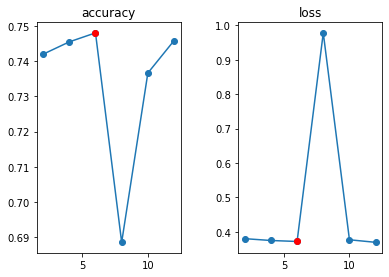

======= Jet 1 =======
Best accuracy : 0.710619640208911 with loss : 0.377908688900218 and value : 8


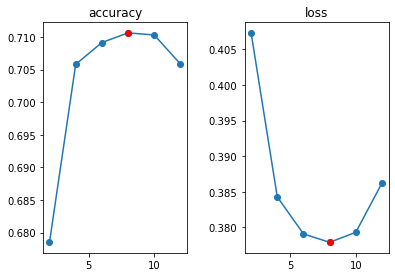

======= Jet 2 and 3 =======
Best accuracy : 0.7518781445999035 with loss : 0.33814178103863113 and value : 12


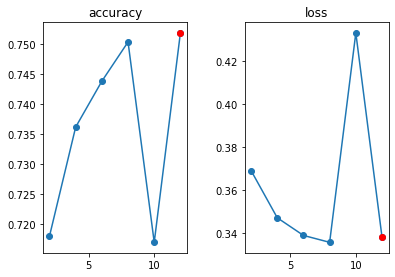

In [19]:
print("======= Jet 0 =======")
best_acc_0, best_loss_0, degree = plot_acc_loss(degrees, a_0, l_0)
print("======= Jet 1 =======")
best_acc_1, best_loss_1, degree = plot_acc_loss(degrees, a_1, l_1)
print("======= Jet 2 and 3 =======")
best_acc_2, best_loss_2, degree = plot_acc_loss(degrees, a_2_3, l_2_3)

#### Ridge Regression

In [20]:
acc_0 = []
loss_0 = []
values_0 = []
acc_1 = []
loss_1 = []
values_1 = []
acc_2_3 = []
loss_2_3 = []
values_2_3 = []
for d in degrees:
        print("====== degree {} ======".format(d))
        deg = np.arange(2, d, 2)
        
        jet_0, jet_1, jet_2_3 = hlp.load_split_data(ML_FOLDER_PATH + "/data/train.csv", one_hot=False)
        jet_0, jet_1, jet_2_3 = hlp.process_data(jet_0, jet_1, jet_2_3, deg=deg)
        jet_0_train, jet_0_val = split_train_val(jet_0, 40)
        jet_1_train, jet_1_val = split_train_val(jet_1, 41)
        jet_2_3_train, jet_2_3_val = split_train_val(jet_2_3, 42)

        id_jet_0_train, y_jet_0_train, x_jet_0_train = split_data(jet_0_train)
        id_jet_0_val, y_jet_0_val, x_jet_0_val = split_data(jet_0_val) 
        id_jet_1_train, y_jet_1_train, x_jet_1_train = split_data(jet_1_train)
        id_jet_1_val, y_jet_1_val, x_jet_1_val = split_data(jet_1_val) 
        id_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_train = split_data(jet_2_3_train)
        id_jet_2_3_val, y_jet_2_3_val, x_jet_2_3_val = split_data(jet_2_3_val) 

        best_acc_0, best_loss_0, value_0 = grid_search_ridge(ridge_values, x_jet_0_train, y_jet_0_train, x_jet_0_val, y_jet_0_val, plot=False)
        acc_0.append(best_acc_0)
        loss_0.append(best_loss_0)
        values_0.append(value_0)

        best_acc_1, best_loss_1, value_1 = grid_search_ridge(ridge_values, x_jet_1_train, y_jet_1_train, x_jet_1_val, y_jet_1_val, plot=False)
        acc_1.append(best_acc_1)
        loss_1.append(best_loss_1)
        values_1.append(value_1)

        best_acc_2_3, best_loss_2_3, value_2_3 = grid_search_ridge(ridge_values, x_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_val, y_jet_2_3_val, plot=False)
        acc_2_3.append(best_acc_2_3)
        loss_2_3.append(best_loss_2_3)
        values_2_3.append(value_2_3)

====== degree 2 ======
Best accuracy : 0.7403793224240605 with loss : 0.3814957080751322 and value : 0.001
Best accuracy : 0.6799277838674318 with loss : 0.4086647763323201 and value : 0.01
Best accuracy : 0.7179681576952237 with loss : 0.3691956171516257 and value : 0.001
====== degree 4 ======
Best accuracy : 0.7413801731471751 with loss : 0.3795995827044658 and value : 0.001
Best accuracy : 0.705203430266297 with loss : 0.4014290972770677 and value : 0.3
Best accuracy : 0.732166241643118 with loss : 0.35133692857482096 and value : 0.001
====== degree 6 ======
Best accuracy : 0.7416804283641095 with loss : 0.38013982254586237 and value : 0.01
Best accuracy : 0.7057192597846412 with loss : 0.3980098464652511 and value : 0.3
Best accuracy : 0.7329243917568405 with loss : 0.34985278409852805 and value : 0.001
====== degree 8 ======
Best accuracy : 0.7419806835810439 with loss : 0.37903233755473825 and value : 0.001
Best accuracy : 0.7056547810948481 with loss : 0.39650100288984547 and v

======= Jet 0 =======
Best accuracy : 0.7426312365510684 with loss : 0.378833855073282 and value : 12


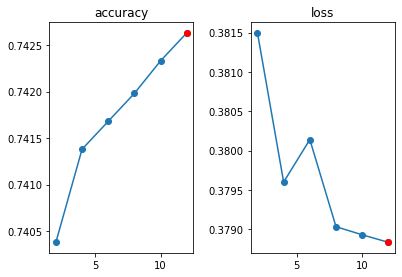

======= Jet 1 =======
Best accuracy : 0.7063640466825714 with loss : 0.39559361489164724 and value : 10


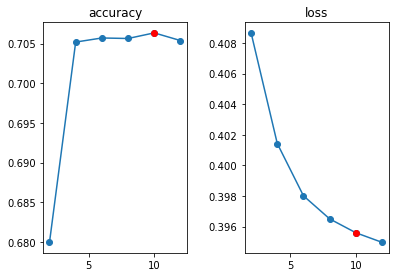

======= Jet 2 and 3 =======
Best accuracy : 0.7338203873457854 with loss : 0.34942040035019517 and value : 10


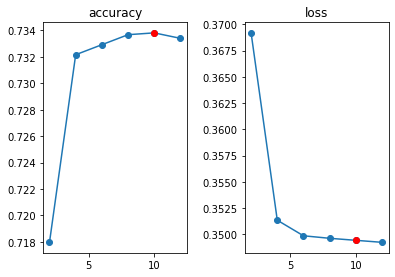

In [21]:
print("======= Jet 0 =======")
best_acc_0, best_loss_0, degree = plot_acc_loss(degrees, acc_0, loss_0)
print("======= Jet 1 =======")
best_acc_1, best_loss_1, degree = plot_acc_loss(degrees, acc_1, loss_1)
print("======= Jet 2 and 3 =======")
best_acc_2, best_loss_2, degree = plot_acc_loss(degrees, acc_2_3, loss_2_3)

#### Gradient descent

In [22]:
acc_0 = []
loss_0 = []
values_0 = []
acc_1 = []
loss_1 = []
values_1 = []
acc_2_3 = []
loss_2_3 = []
values_2_3 = []
for d in degrees:
        print("====== degree {} ======".format(d))
        deg = np.arange(2, d, 2)

        jet_0, jet_1, jet_2_3 = hlp.load_split_data(ML_FOLDER_PATH + "/data/train.csv", one_hot=False)
        jet_0, jet_1, jet_2_3 = hlp.process_data(jet_0, jet_1, jet_2_3, deg=deg)
        jet_0_train, jet_0_val = split_train_val(jet_0, 40)
        jet_1_train, jet_1_val = split_train_val(jet_1, 41)
        jet_2_3_train, jet_2_3_val = split_train_val(jet_2_3, 42)

        id_jet_0_train, y_jet_0_train, x_jet_0_train = split_data(jet_0_train)
        id_jet_0_val, y_jet_0_val, x_jet_0_val = split_data(jet_0_val) 
        id_jet_1_train, y_jet_1_train, x_jet_1_train = split_data(jet_1_train)
        id_jet_1_val, y_jet_1_val, x_jet_1_val = split_data(jet_1_val) 
        id_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_train = split_data(jet_2_3_train)
        id_jet_2_3_val, y_jet_2_3_val, x_jet_2_3_val = split_data(jet_2_3_val) 

        best_acc_0, best_loss_0, value_0 = grid_search_gamma(gammas, x_jet_0_train, y_jet_0_train, x_jet_0_val, y_jet_0_val, plot=False)
        acc_0.append(best_acc_0)
        loss_0.append(best_loss_0)
        values_0.append(value_0)

        best_acc_1, best_loss_1, value_1 = grid_search_gamma(gammas, x_jet_1_train, y_jet_1_train, x_jet_1_val, y_jet_1_val, plot=False)
        acc_1.append(best_acc_1)
        loss_1.append(best_loss_1)
        values_1.append(value_1)

        best_acc_2_3, best_loss_2_3, value_2_3 = grid_search_gamma(gammas, x_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_val, y_jet_2_3_val, plot=False)
        acc_2_3.append(best_acc_2_3)
        loss_2_3.append(best_loss_2_3)
        values_2_3.append(value_2_3)

====== degree 2 ======
99.00%Best accuracy : 0.7368263023570034 with loss : 0.38477908824811524 and value : 0.1
99.00%Best accuracy : 0.6799277838674318 with loss : 0.4104727194537573 and value : 0.2
99.00%Best accuracy : 0.7152112481907782 with loss : 0.3707986358302914 and value : 0.3
====== degree 4 ======
99.00%Best accuracy : 0.7390782164840114 with loss : 0.3803562788166583 and value : 0.2
99.00%Best accuracy : 0.7020439744664388 with loss : 0.3933601176770395 and value : 0.1
99.00%Best accuracy : 0.7208629126748914 with loss : 0.36478702913025374 and value : 0.1
====== degree 6 ======
99.00%Best accuracy : 0.7318220487414302 with loss : 0.3831527747838918 and value : 0.1
99.00%Best accuracy : 0.7021729318460249 with loss : 0.39490583566906406 and value : 0.1
99.00%Best accuracy : 0.7252739678820043 with loss : 0.36274324791343326 and value : 0.1
====== degree 8 ======
99.00%Best accuracy : 0.7277185607766602 with loss : 0.38529942691015784 and value : 0.1
99.00%Best accuracy : 0

======= Jet 0 =======
Best accuracy : 0.7390782164840114 with loss : 0.3803562788166583 and value : 4


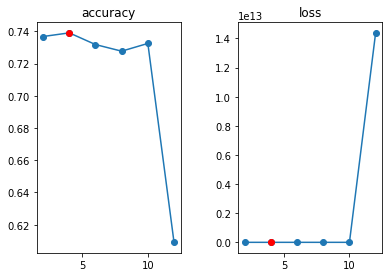

======= Jet 1 =======
Best accuracy : 0.7021729318460249 with loss : 0.39490583566906406 and value : 6


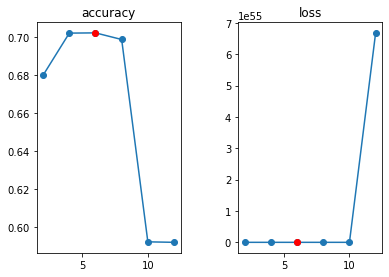

======= Jet 2 and 3 =======
Best accuracy : 0.7252739678820043 with loss : 0.36274324791343326 and value : 6


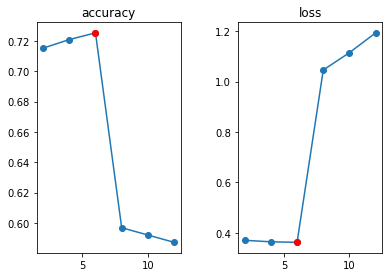

In [23]:
print("======= Jet 0 =======")
best_acc_0, best_loss_0, degree = plot_acc_loss(degrees, acc_0, loss_0)
print("======= Jet 1 =======")
best_acc_1, best_loss_1, degree = plot_acc_loss(degrees, acc_1, loss_1)
print("======= Jet 2 and 3 =======")
best_acc_2, best_loss_2, degree = plot_acc_loss(degrees, acc_2_3, loss_2_3)

#### Stochastic gradient descent

In [24]:
acc_0 = []
loss_0 = []
values_0 = []
acc_1 = []
loss_1 = []
values_1 = []
acc_2_3 = []
loss_2_3 = []
values_2_3 = []
for d in degrees:
        print("====== degree {} ======".format(d))
        deg = np.arange(2, d, 2)
        jet_0, jet_1, jet_2_3 = hlp.load_split_data(ML_FOLDER_PATH + "/data/train.csv", one_hot=False)
        jet_0, jet_1, jet_2_3 = hlp.process_data(jet_0, jet_1, jet_2_3, deg=deg)
        jet_0_train, jet_0_val = split_train_val(jet_0, 40)
        jet_1_train, jet_1_val = split_train_val(jet_1, 41)
        jet_2_3_train, jet_2_3_val = split_train_val(jet_2_3, 42)

        id_jet_0_train, y_jet_0_train, x_jet_0_train = split_data(jet_0_train)
        id_jet_0_val, y_jet_0_val, x_jet_0_val = split_data(jet_0_val) 
        id_jet_1_train, y_jet_1_train, x_jet_1_train = split_data(jet_1_train)
        id_jet_1_val, y_jet_1_val, x_jet_1_val = split_data(jet_1_val) 
        id_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_train = split_data(jet_2_3_train)
        id_jet_2_3_val, y_jet_2_3_val, x_jet_2_3_val = split_data(jet_2_3_val) 

        best_acc_0, best_loss_0, value_0 = grid_search_stoch_gamma(gammas, x_jet_0_train, y_jet_0_train, x_jet_0_val, y_jet_0_val, plot=False)
        acc_0.append(best_acc_0)
        loss_0.append(best_loss_0)
        values_0.append(value_0)

        best_acc_1, best_loss_1, value_1 = grid_search_stoch_gamma(gammas, x_jet_1_train, y_jet_1_train, x_jet_1_val, y_jet_1_val, plot=False)
        acc_1.append(best_acc_1)
        loss_1.append(best_loss_1)
        values_1.append(value_1)

        best_acc_2_3, best_loss_2_3, value_2_3 = grid_search_stoch_gamma(gammas, x_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_val, y_jet_2_3_val, plot=False)
        acc_2_3.append(best_acc_2_3)
        loss_2_3.append(best_loss_2_3)
        values_2_3.append(value_2_3)

====== degree 2 ======
Best accuracy : 0.6733223239753791 with loss : 453.656105532259 and value : 0.1
Best accuracy : 0.5525823715262106 with loss : 5.327520704485775 and value : 0.001
Best accuracy : 0.5866703425460059 with loss : 0.8617142756261191 and value : 0.01
====== degree 4 ======
Best accuracy : 0.6292848921583346 with loss : 2.8435690862110596e+36 and value : 0.2
Best accuracy : 0.5579985814688245 with loss : 8.003074864103947 and value : 0.001
Best accuracy : 0.6169963470949066 with loss : 6.765429205788464e+56 and value : 0.2
====== degree 6 ======
Best accuracy : 0.6830806185257469 with loss : 1.147986386179553e+30 and value : 0.1
Best accuracy : 0.6149977432458572 with loss : 9.827627752648125e+67 and value : 0.2
Best accuracy : 0.6058308636019023 with loss : 3.941898705568748 and value : 0.01
====== degree 8 ======
Best accuracy : 0.6299354451283591 with loss : 1.2567930874786808 and value : 0.01
Best accuracy : 0.6162228383519247 with loss : 2.1900495103161215e+85 and

======= Jet 0 =======
Best accuracy : 0.6830806185257469 with loss : 1.147986386179553e+30 and value : 6


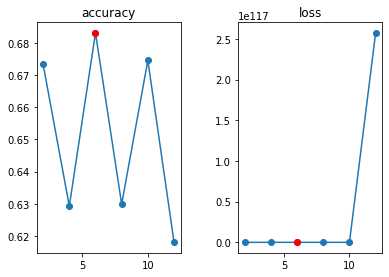

======= Jet 1 =======
Best accuracy : 0.6174479334579921 with loss : 2.1931060479694e+115 and value : 12


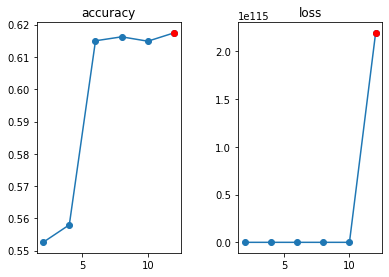

======= Jet 2 and 3 =======
Best accuracy : 0.6291267489144668 with loss : 7.650708401213845e+110 and value : 8


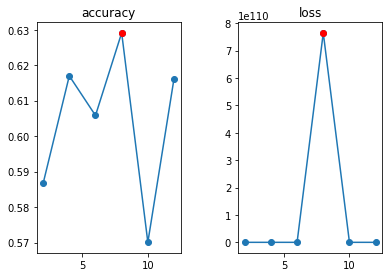

In [25]:
print("======= Jet 0 =======")
best_acc_0, best_loss_0, degree = plot_acc_loss(degrees, acc_0, loss_0)
print("======= Jet 1 =======")
best_acc_1, best_loss_1, degree = plot_acc_loss(degrees, acc_1, loss_1)
print("======= Jet 2 and 3 =======")
best_acc_2, best_loss_2, degree = plot_acc_loss(degrees, acc_2_3, loss_2_3)

#### Logistic regression

In [26]:
acc_0 = []
loss_0 = []
values_0 = []
acc_1 = []
loss_1 = []
values_1 = []
acc_2_3 = []
loss_2_3 = []
values_2_3 = []
for d in degrees:
        print("====== degree {} ======".format(d))
        deg = np.arange(2, d, 2)
        jet_0, jet_1, jet_2_3 = hlp.load_split_data(ML_FOLDER_PATH + "/data/train.csv", one_hot=True)
        jet_0, jet_1, jet_2_3 = hlp.process_data(jet_0, jet_1, jet_2_3, deg=deg)
        jet_0_train, jet_0_val = split_train_val(jet_0, 40)
        jet_1_train, jet_1_val = split_train_val(jet_1, 41)
        jet_2_3_train, jet_2_3_val = split_train_val(jet_2_3, 42)

        id_jet_0_train, y_jet_0_train, x_jet_0_train = split_data(jet_0_train)
        id_jet_0_val, y_jet_0_val, x_jet_0_val = split_data(jet_0_val) 
        id_jet_1_train, y_jet_1_train, x_jet_1_train = split_data(jet_1_train)
        id_jet_1_val, y_jet_1_val, x_jet_1_val = split_data(jet_1_val) 
        id_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_train = split_data(jet_2_3_train)
        id_jet_2_3_val, y_jet_2_3_val, x_jet_2_3_val = split_data(jet_2_3_val) 

        best_acc_0, best_loss_0, value_0 = grid_search_log_gamma(gammas, x_jet_0_train, y_jet_0_train, x_jet_0_val, y_jet_0_val, plot=False)
        acc_0.append(best_acc_0)
        loss_0.append(best_loss_0)
        values_0.append(value_0)

        best_acc_1, best_loss_1, value_1 = grid_search_log_gamma(gammas, x_jet_1_train, y_jet_1_train, x_jet_1_val, y_jet_1_val, plot=False)
        acc_1.append(best_acc_1)
        loss_1.append(best_loss_1)
        values_1.append(value_1)

        best_acc_2_3, best_loss_2_3, value_2_3 = grid_search_log_gamma(gammas, x_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_val, y_jet_2_3_val, plot=False)
        acc_2_3.append(best_acc_2_3)
        loss_2_3.append(best_loss_2_3)
        values_2_3.append(value_2_3)

====== degree 2 ======
Best accuracy : 0.8044337687033979 with loss : 0.561987294681909 and value : 0.3
Best accuracy : 0.7097169385518086 with loss : 0.5961839943481552 and value : 0.3
Best accuracy : 0.723619822179337 with loss : 0.5486995950198031 and value : 0.3
====== degree 4 ======


c:\Users\danie\Documents\Drive_EPFL\MA1\Machine_Learning\projet1\ML_proj1\src\helpers.py:81: RuntimeWarning: divide by zero encountered in log
  loss = (-1 / len(y)) * (y.T.dot(np.log(y_hat)) + (1 - y).T.dot(np.log(1 - y_hat)))


Best accuracy : 0.807786618625832 with loss : 0.556790438962822 and value : 0.3
Best accuracy : 0.7424076342768715 with loss : 0.5723497313658766 and value : 0.3
Best accuracy : 0.7340271555586187 with loss : 0.5254637365286563 and value : 0.3
====== degree 6 ======
Best accuracy : 0.8063854276134714 with loss : 0.5566758766454776 and value : 0.3
Best accuracy : 0.7444064736604552 with loss : 0.5705455987665845 and value : 0.3
Best accuracy : 0.7338203873457854 with loss : 0.5238681245930153 and value : 0.3
====== degree 8 ======
Best accuracy : 0.8066356402942502 with loss : 0.5566314254407807 and value : 0.3
Best accuracy : 0.7448578244890064 with loss : 0.5725920302752974 and value : 0.3
Best accuracy : 0.7340271555586187 with loss : 0.5230978807630252 and value : 0.3
====== degree 10 ======
Best accuracy : 0.8064354701496271 with loss : 0.5574894253703467 and value : 0.2
Best accuracy : 0.7442775162808691 with loss : 0.5708126639691015 and value : 0.3
Best accuracy : 0.735956992211

======= Jet 0 =======
Best accuracy : 0.807786618625832 with loss : 0.556790438962822 and value : 4


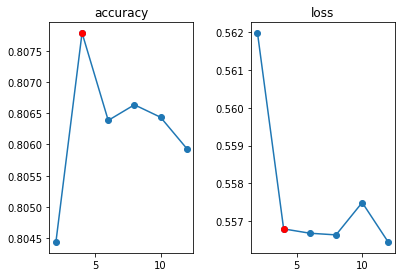

======= Jet 1 =======
Best accuracy : 0.7448578244890064 with loss : 0.5725920302752974 and value : 8


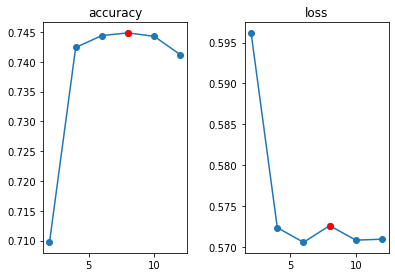

======= Jet 2 and 3 =======
Best accuracy : 0.7364394513750087 with loss : 0.5217700769293494 and value : 12


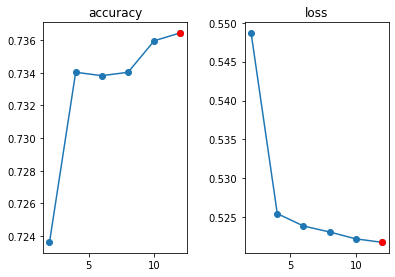

In [27]:
print("======= Jet 0 =======")
best_acc_0, best_loss_0, degree = plot_acc_loss(degrees, acc_0, loss_0)
print("======= Jet 1 =======")
best_acc_1, best_loss_1, degree = plot_acc_loss(degrees, acc_1, loss_1)
print("======= Jet 2 and 3 =======")
best_acc_2, best_loss_2, degree = plot_acc_loss(degrees, acc_2_3, loss_2_3)

#### Regularized logistic regression

In [28]:
acc_0 = []
loss_0 = []
values_0 = []
acc_1 = []
loss_1 = []
values_1 = []
acc_2_3 = []
loss_2_3 = []
values_2_3 = []
for d in degrees:
        print("====== degree {} ======".format(d))
        deg = np.arange(2, d, 2)
        jet_0, jet_1, jet_2_3 = hlp.load_split_data(ML_FOLDER_PATH + "/data/train.csv", one_hot=True)
        jet_0, jet_1, jet_2_3 = hlp.process_data(jet_0, jet_1, jet_2_3, deg=deg)
        jet_0_train, jet_0_val = split_train_val(jet_0, 40)
        jet_1_train, jet_1_val = split_train_val(jet_1, 41)
        jet_2_3_train, jet_2_3_val = split_train_val(jet_2_3, 42)

        id_jet_0_train, y_jet_0_train, x_jet_0_train = split_data(jet_0_train)
        id_jet_0_val, y_jet_0_val, x_jet_0_val = split_data(jet_0_val) 
        id_jet_1_train, y_jet_1_train, x_jet_1_train = split_data(jet_1_train)
        id_jet_1_val, y_jet_1_val, x_jet_1_val = split_data(jet_1_val) 
        id_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_train = split_data(jet_2_3_train)
        id_jet_2_3_val, y_jet_2_3_val, x_jet_2_3_val = split_data(jet_2_3_val) 

        best_acc_0, best_loss_0, value_0 = grid_search_reg_log_gamma(gammas, lambdas_, x_jet_0_train, y_jet_0_train, x_jet_0_val, y_jet_0_val, plot=False)
        acc_0.append(best_acc_0)
        loss_0.append(best_loss_0)
        values_0.append(value_0)

        best_acc_1, best_loss_1, value_1 = grid_search_reg_log_gamma(gammas, lambdas_, x_jet_1_train, y_jet_1_train, x_jet_1_val, y_jet_1_val, plot=False)
        acc_1.append(best_acc_1)
        loss_1.append(best_loss_1)
        values_1.append(value_1)

        best_acc_2_3, best_loss_2_3, value_2_3 = grid_search_reg_log_gamma(gammas, lambdas_, x_jet_2_3_train, y_jet_2_3_train, x_jet_2_3_val, y_jet_2_3_val, plot=False)
        acc_2_3.append(best_acc_2_3)
        loss_2_3.append(best_loss_2_3)
        values_2_3.append(value_2_3)



====== degree 2 ======
Lambda value : 0.001
Best accuracy : 0.8014812590702097 with loss : 0.5653323558000196 and value : 0.3
Lambda value : 0.1
Best accuracy : 0.807386278336586 with loss : 0.586356498703747 and value : 0.1
Lambda value : 0.3
Best accuracy : 0.8080368313066106 with loss : 0.6112061439583117 and value : 0.2
Lambda value : 0.001
Best accuracy : 0.7056547810948481 with loss : 0.6001179874733 and value : 0.3
Lambda value : 0.1
Best accuracy : 0.6974015088013411 with loss : 0.6164759644930083 and value : 0.1
Lambda value : 0.3
Best accuracy : 0.6788316461409504 with loss : 0.6344801668595248 and value : 0.1
Lambda value : 0.001
Best accuracy : 0.7196912261355021 with loss : 0.55606977215212 and value : 0.3
Lambda value : 0.1
Best accuracy : 0.7134192570128886 with loss : 0.5738512145532167 and value : 0.1
Lambda value : 0.3
Best accuracy : 0.6887449169481011 with loss : 0.6024602628467212 and value : 0.2
====== degree 4 ======
Lambda value : 0.001
Best accuracy : 0.8046339

======= Jet 0 =======
Best accuracy : 0.8109392984036431 with loss : 0.5923931851179841 and value : 4


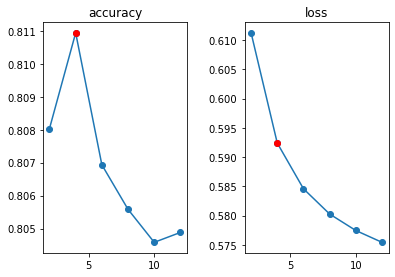

======= Jet 1 =======
Best accuracy : 0.7307369914243342 with loss : 0.5895935309975759 and value : 12


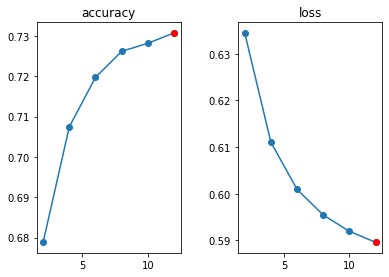

======= Jet 2 and 3 =======
Best accuracy : 0.7213453718381694 with loss : 0.5474587508087013 and value : 10


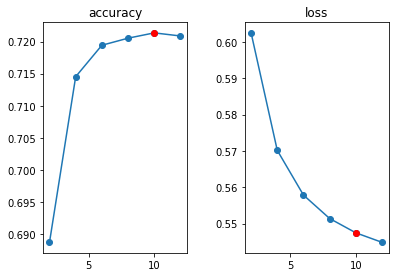

In [29]:
print("======= Jet 0 =======")
best_acc_0, best_loss_0, degree = plot_acc_loss(degrees, acc_0, loss_0)
print("======= Jet 1 =======")
best_acc_1, best_loss_1, degree = plot_acc_loss(degrees, acc_1, loss_1)
print("======= Jet 2 and 3 =======")
best_acc_2, best_loss_2, degree = plot_acc_loss(degrees, acc_2_3, loss_2_3)